# Tutorial Sesión 1: Estudio de Transfer Learning con TensorFlow

Tutorial de Transfer Learning y Fine Tuning.  

TMO: Técnicas metaheurísticas y de optimización.
[Máster en Data Science y Big Data](http://masterds.es/) de la [Universidad de Sevilla](http://www.us.es). 

Profesor: [Miguel Ángel Martínez del Amor](http://www.cs.us.es/~mdelamor)

## Tabla de Contenidos

* [1. Introducción](#intro)
* [2. Jugando con Inception V3](#inception)
  * [2.1 Arquitectura de la red](#inceparq)
  * [2.2 Importación de librerías y descarga del modelo](#incepimp)
  * [2.3 Clasificación de imágenes](#incepclasif)
  * [2.4 Experimentación y cierre de sesión](#incepcierre)
  * [2.5 Conclusiones](#incepconclu)
* [3. Estudio de Transferibilidad](#datatransfer)
  * [3.1 El Dataset: Knifey-Spoony](#transferdata)
  * [3.2 Funciones Auxiliares](#transferaux)
  * [3.3 Dibujar Algunas Imágenes de Prueba](#transferprueba)
  * [3.4 Descarga del Modelo Inception](#transfermodelo)
  * [3.5 Cálculo de Valores de Transferencia](#transfercalc)
  * [3.6 Función Auxiliar para Mostrar Valores de Transferencia](#transfergraphval)
  * [3.7 Análisis de Valores de Transferencia mediante PCA](#transferpca)
  * [3.8 Análisis de Valores de Transferencia mediante t-SNE](#transfertsne)
  * [3.9 Conclusiones](#transferconc)

## 1. Introducción <a class="anchor" id="intro"></a>

En este tutorial profundizaremos más en el concepto de transfer learning (transferencia de aprendizaje), siendo aplicado a visión por computador. Comenzaremos utilizando un modelo pre-entrenado en algunas imágenes, comprendiendo qué es lo que podemos obtener de ellos. A continuación, intentaremos entrenar una red sobre un conjunto de imágenes para posteriormente mejorarlo con modelos pre-entrenados mediante transfer learning y fine tuning, visualizando qué comportamiento obtendremos.

En este tutorial utilizaremos [Keras](https://keras.io/), una API de alta abstracción que se puede usar sobre [TensorFlow](https://www.tensorflow.org). Usaremos primero el modelo Inception V3, y posteriormente para trabajar el VGG16, dado que su arquitectura es más sencilla. Se aconseja emplear una [GPU con arquitectura para Deep Learning](https://timdettmers.com/2019/04/03/which-gpu-for-deep-learning/) (recomendado una GPU de NVIDIA con arquitectura Kepler, Pascal, Volta o Turing), por lo que si no se tiene una en local se recomienda acceder a un servidor o a una plataforma en la nube como [Google Colab](https://colab.research.google.com/).

Antes de continuar, se debe tener un mínimo de conocimiento sobre Machine Learning, y también algunas nociones básicas de Deep Learning, como por ejemplo comprender que son las características y cómo las aprende una red neuronal profunda. Para entender ésto último de forma visual, se recomienda este vídeo.

In [1]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/AgkfIQ4IGaM" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


/home/miguel/.local/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## 2. Jugando con Inception V3 <a class="anchor" id="inception"></a>

Este tutorial muestra cómo usar una Red Neural Profunda pre-entrenada llamada Inception v3 para la clasificación de imágenes.

El modelo Inception v3 tardó semanas en entrenarse sobre ImageNet (millones de imágenes) en un ordenador con 8 GPUs Tesla K40 que probablemente cuesta 30.000 euros, por lo que es imposible entrenarlo en un PC normal. En su lugar, descargaremos el modelo de Inception previamente entrenado y lo usaremos para clasificar las imágenes.

El modelo Inception v3 tiene casi 25 millones de parámetros y utiliza 5.000 millones de operaciones de multiplicación para clasificar una sola imagen. En un PC moderno sin GPU, esto se puede hacer en una fracción de segundo por imagen.

Este tutorial oculta el código TensorFlow, por lo que puede que no requiera mucha experiencia con TensorFlow, aunque una comprensión básica de TensorFlow puede ser útil, especialmente si desea estudiar los detalles de implementación en el archivo [`inception.py`](./inception.py).

### 2.1. Arquitectura de la red <a class="anchor" id="inceparq"></a>

La siguiente figura muestra cómo fluyen los datos en el modelo Inception v3, que es una Red Neural Convolucional con muchas capas y una estructura complicada. El [artículo](http://arxiv.org/pdf/1512.00567v3.pdf) ofrece más detalles sobre cómo se construye el modelo Inception y por qué se diseña de esa manera. Pero los autores admiten que no entienden del todo por qué funciona. 

Ten en cuenta que el modelo Inception tiene dos salidas softmax. Uno se usa durante el entrenamiento de la red neural como regularizador y el otro se usa para clasificar imágenes después de que el entrenamiento haya terminado, es decir, para inferencia. Para entender mejor los detalles de la red, se puede leer este [artículo](https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c).

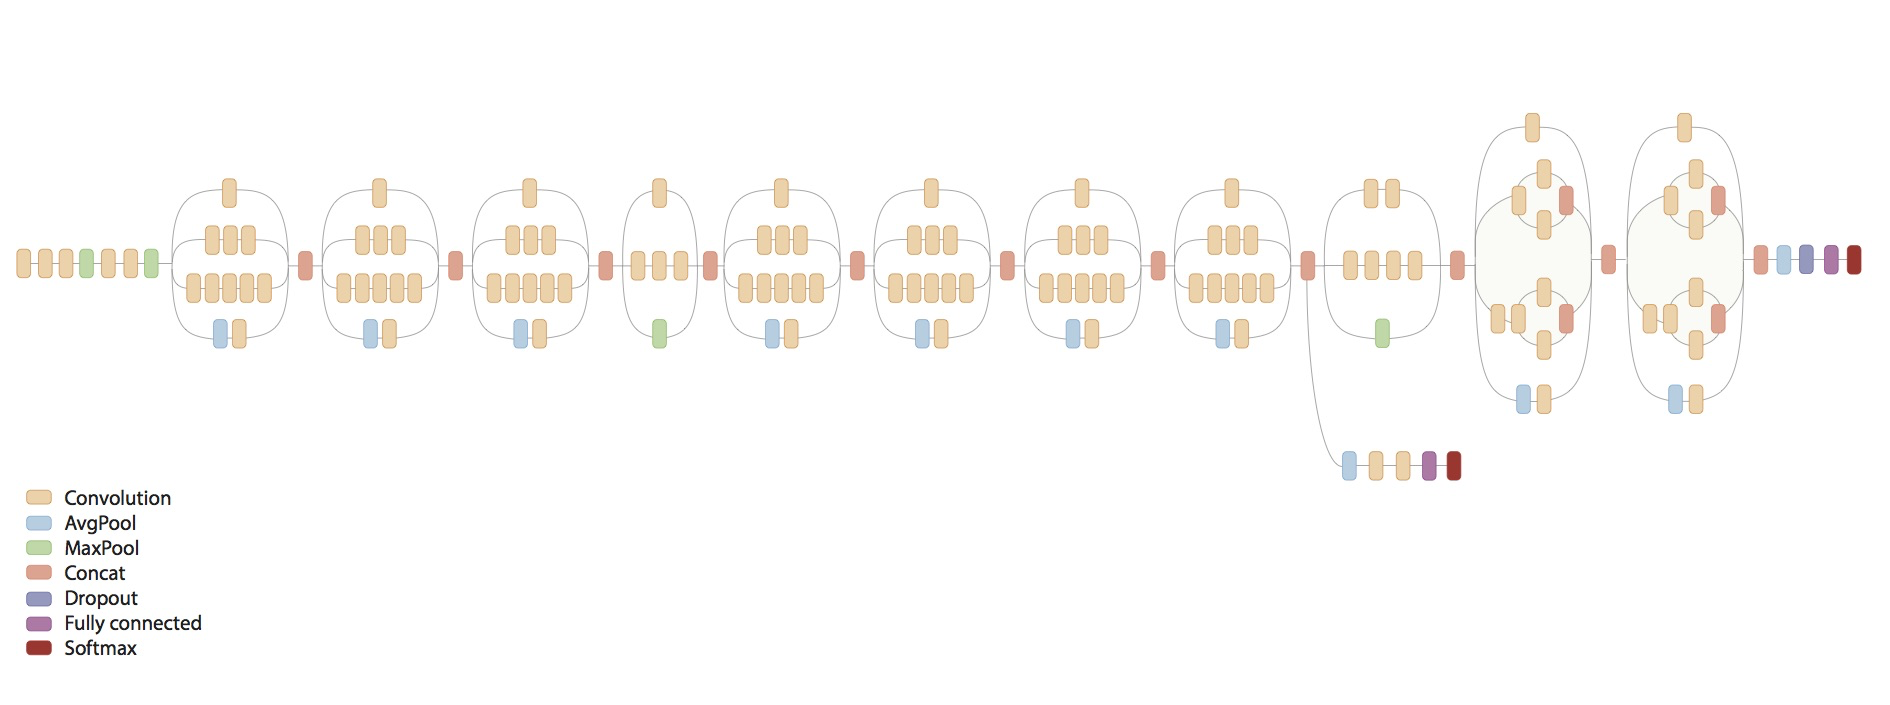

In [2]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')

### 2.2 Importación de librerías y descarga del modelo <a class="anchor" id="incepimp"></a>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Archivo auxiliar 'inception.py' con funciones y clases para cargar y usar el modelo inception
import inception

# Comprobar nuestra versión de tensorflow
tf.__version__

'1.13.1'

El modelo Inception se descarga desde internet. Esta es la carpeta por defecto donde se descarán los ficheros correspondientes. El directorio se creará si no existe.

In [10]:
# inception.data_dir = 'inception/'

Si aún no has descargado el modelo, lo puedes hacer con la siguiente instrucción. Tomará unos 85Mb.

In [4]:
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


Por último, carga el modelo para poder emplearlo a continuación.

In [5]:
model = inception.Inception()

Instructions for updating:
Use tf.gfile.GFile.


### 2.3 Clasificación de imágenes <a class="anchor" id="incepclasif"></a>

Antes de continuar, vamos a definir una función auxiliar que nos ayudará en la tarea de clasificar imágenes: muestra la imagen, la clasifica usando el modelo cargado, e imprime las puntuaciones (scores) de clasificación.

In [6]:
def classify(image_path):
    # Muestra la imagen.
    display(Image(image_path))

    # Usa el modelo Inception para clasificar la imagen.
    pred = model.classify(image_path=image_path)

    # Muestra los scores y los nombres del top-10 de las predicciones.
    model.print_scores(pred=pred, k=10, only_first_name=True)   

#### Panda

Esta imagen de un panda se incluye en el archivo de datos de Inception. El modelo Inception está bastante seguro de que esta imagen muestra un panda, con una puntuación de clasificación de alrededor del 89% y la siguiente puntuación más alta es de sólo alrededor del 0,8% para un indri, que es otro animal exótico.

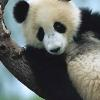

89.11% : giant panda
 0.78% : indri
 0.30% : lesser panda
 0.15% : custard apple
 0.12% : earthstar
 0.09% : sea urchin
 0.05% : forklift
 0.05% : digital watch
 0.05% : gibbon
 0.05% : go-kart


In [7]:
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')
classify(image_path)

#### Interpretación de las puntuaciones de clasificación

El resultado del modelo Inception es la llamada función **Softmax**. Las salidas softmax son a veces llamadas probabilidades porque están entre cero y uno, y también suman uno - igual que las probabilidades. Pero en realidad no son probabilidades en el sentido tradicional de la palabra, porque no provienen de experimentos repetidos.

Tal vez sea mejor llamar a los valores de salida de una red neuronal las *puntuaciones o rangos de clasificación*, porque indican con qué certeza cree la red que la imagen de entrada es de cada clase posible.

En el ejemplo anterior con la imagen de un panda, el modelo Inception dio una puntuación muy alta de alrededor del 89% para la clase panda, y las puntuaciones para las 999 clases posibles restantes estaban todas por debajo del 1%. Esto significa que el modelo de Inception estaba bastante seguro de que la imagen mostraba un panda y que las puntuaciones restantes por debajo del 1% debían considerarse como ruido. Por ejemplo, la octava puntuación más alta fue del 0,05% para un reloj digital, pero esto se debe probablemente más a la naturaleza imprecisa de las redes neuronales que a una indicación de que la imagen se parecía ligeramente a un reloj digital.

A veces el modelo Inception se confunde con la clase a la que pertenece una imagen, por lo que ninguna de las puntuaciones es realmente alta. A continuación se muestran ejemplos de ello.

#### Loro (Parrot)
##### Imagen Original

El modelo Inception está muy seguro (puntuación sobre 97%) de que esta imagen muestra un tipo de loro llamado guacamayo (macaw).

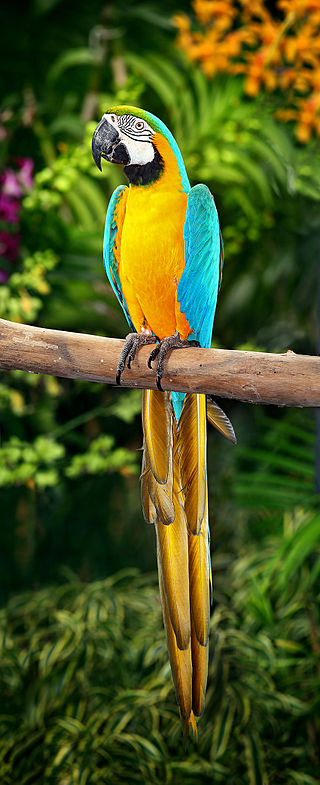

97.18% : macaw
 0.07% : African grey
 0.06% : toucan
 0.05% : jacamar
 0.04% : bee eater
 0.03% : lorikeet
 0.02% : sulphur-crested cockatoo
 0.02% : jay
 0.01% : kite
 0.01% : indigo bunting


In [8]:
classify(image_path="images/parrot.jpg")

##### Imagen Redimensionada

El modelo Inception funciona con imágenes de entrada de 299 x 299 píxeles de tamaño. La imagen de arriba de un loro tiene en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente por el modelo Inception.

Ahora queremos ver la imagen después de que haya sido redimensionada por el modelo Inception. Primero tenemos una función de ayuda para obtener la imagen redimensionada desde dentro del modelo Inception.

In [9]:
def plot_resized_image(image_path):
    # Toma la imagen redimensionada del modelo Inception
    resized_image = model.get_resized_image(image_path=image_path)

    # Muestra la imagen.
    plt.imshow(resized_image, interpolation='nearest')
    
    # Se asegura de que la gráfica se muestre.
    plt.show()

Ahora traza la imagen del loro al nuevo tamaño. Esta es la imagen que se introduce en la red neuronal del modelo Inception. Podemos ver que ha sido apretado para que sea cuadrado, y la resolución se ha reducido para que la imagen sea más pixelada y granulada.

En este caso, la imagen todavía muestra claramente un loro, pero algunas imágenes pueden distorsionarse tanto a partir de este ingenuo cambio de tamaño que puede que desees cambiar el tamaño de las imágenes tú mismo antes de introducirlas en el modelo Inception.

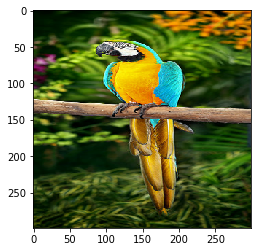

In [10]:
plot_resized_image(image_path="images/parrot.jpg")

##### Imagen Recortada, arriba

Esta imagen del loro se ha recortado manualmente a 299 x 299 píxeles y luego se ha introducido en el modelo Inception,
que sigue estando muy seguro (puntuación de alrededor del 97%) de que muestra un loro (guacamayo).

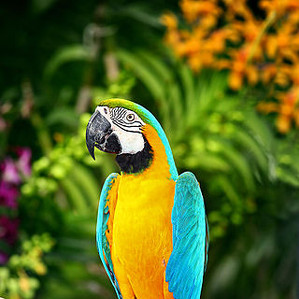

97.52% : macaw
 0.09% : African grey
 0.03% : sulphur-crested cockatoo
 0.02% : toucan
 0.02% : reflex camera
 0.01% : comic book
 0.01% : backpack
 0.01% : bib
 0.01% : vulture
 0.01% : lens cap


In [11]:
classify(image_path="images/parrot_cropped1.jpg")

##### Imagen Recortada, en el centro

Esto es otro recorte de la imagen del loro, esta vez mostrando su cuerpo sin cabeza ni cola. El modelo Inception sigue teniendo mucha confianza (puntuación de alrededor del 94%) de que muestra un loro guacamayo.

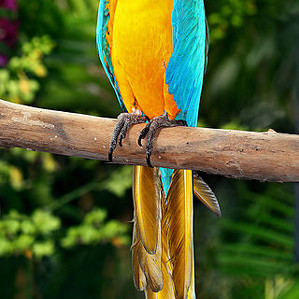

94.21% : macaw
 0.76% : toucan
 0.58% : African grey
 0.11% : jacamar
 0.10% : sulphur-crested cockatoo
 0.10% : bee eater
 0.09% : magpie
 0.08% : jay
 0.06% : lorikeet
 0.04% : hornbill


In [12]:
classify(image_path="images/parrot_cropped2.jpg")

##### Imagen Recortada, abajo

Esta imagen ha sido recortada por lo que sólo muestra la cola del loro. Ahora el modelo Inception está bastante confundido y piensa que la imagen podría mostrar un jacamar (puntuación de alrededor del 26%) que es otro ave exótica, o quizás la imagen muestra un saltamontes (grass-hopper, puntuación de alrededor del 10%).

El modelo Inception también piensa que la imagen podría mostrar una pluma estilográfica (fountain-pen, puntuación aproximada del 2%). Pero esta es una puntuación muy baja y debe interpretarse como un ruido poco fiable.

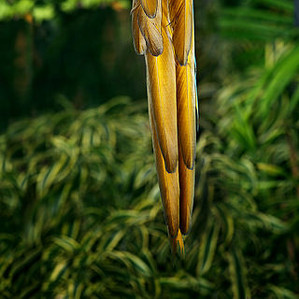

26.51% : jacamar
10.56% : grasshopper
 3.58% : chime
 2.15% : bulbul
 1.93% : fountain pen
 1.64% : leafhopper
 1.31% : kite
 1.22% : cricket
 1.09% : macaw
 0.81% : bee eater


In [13]:
classify(image_path="images/parrot_cropped3.jpg")

##### Imagen Rellenada

La mejor manera de introducir imágenes en este modelo Inception, es rellenar la imagen para que sea cuadrada (en blanco a los lados) y luego redimensionarla a 299 x 299 píxeles, como este ejemplo del loro que está clasificado correctamente con una puntuación de alrededor del 97%.

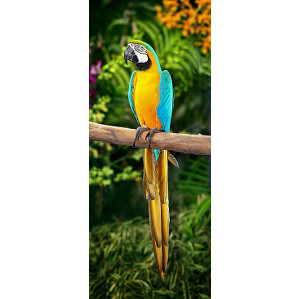

96.87% : macaw
 0.06% : African grey
 0.06% : toucan
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo
 0.03% : king penguin
 0.03% : jacamar
 0.03% : lorikeet
 0.01% : kite
 0.01% : anemone fish


In [14]:
classify(image_path="images/parrot_padded.jpg")

#### Elon Musk

##### 299 x 299 píxeles

Esta imagen muestra a la leyenda viviente Elon Musk. Pero el modelo de Inception está muy confundido sobre lo que muestra la imagen, prediciendo que puede mostrar una sudadera (sweatshirt, puntuación alrededor del 17%) o una abaya (puntuación alrededor del 16%). También piensa que la imagen podría mostrar una pelota de ping-pong (ping-pong ball, puntuación de alrededor del 3%) o una pelota de béisbol (baseball, puntuación de alrededor del 2%). Por lo tanto, el modelo Inception está confuso y las puntuaciones de la clasificación no son fiables.

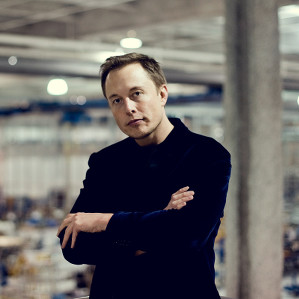

16.63% : sweatshirt
16.45% : abaya
 4.62% : suit
 3.40% : ping-pong ball
 2.89% : trench coat
 2.37% : baseball
 2.31% : cellular telephone
 1.99% : jersey
 1.42% : water bottle
 1.34% : dumbbell


In [15]:
classify(image_path="images/elon_musk.jpg")

##### 100 x 100 píxeles

Si en su lugar usamos una imagen de 100 x 100 píxeles de Elon Musk, entonces el modelo de Inception piensa que podría mostrar una sudadera (sweatshirt, puntuación alrededor del 22%) o una bota de vaquero (cowboy boot, puntuación alrededor del 14%). Así que ahora el modelo Inception tiene predicciones algo diferentes, pero sigue estando muy confuso.

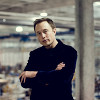

21.65% : sweatshirt
14.51% : cowboy boot
 9.11% : abaya
 8.70% : balance beam
 5.92% : suit
 5.65% : Loafer
 3.66% : trench coat
 1.75% : maillot
 1.44% : jersey
 1.44% : unicycle


In [16]:
classify(image_path="images/elon_musk_100x100.jpg")

El modelo Inception escala automáticamente el tamaño de esta imagen de 100 x 100 a 299 x 299 píxeles, que se muestra aquí. Observa lo pixelado y granuloso que realmente es, aunque un humano puede ver fácilmente que esta es la imagen de un hombre con los brazos cruzados.

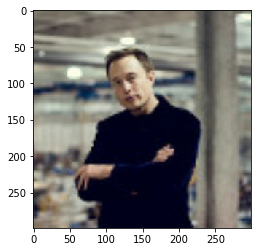

In [17]:
plot_resized_image(image_path="images/elon_musk_100x100.jpg")

#### Willy Wonka 

##### Gene Wilder

Esta imagen muestra al actor Gene Wilder interpretando a Willy Wonka en la versión de la película de 1971. El modelo Inception está muy seguro de que la imagen muestra una pajarita (bow tie, puntuación de alrededor del 98%), lo que es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo Inception fue entrenado en imágenes de personas con pajaritas que fueron clasificadas como pajaritas en lugar de personas. Así que tal vez el problema es que el nombre de la clase debería ser "persona con pajarita" en lugar de sólo "pajarita".

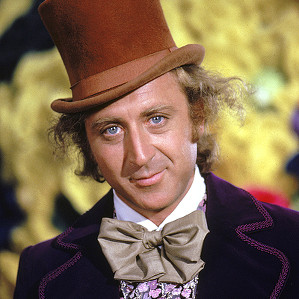

97.98% : bow tie
 0.63% : cowboy hat
 0.14% : sombrero
 0.07% : suit
 0.05% : bolo tie
 0.04% : Windsor tie
 0.03% : cornet
 0.02% : flute
 0.02% : banjo
 0.01% : revolver


In [18]:
classify(image_path="images/willy_wonka_old.jpg")

##### Johnny Depp

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión de 2005 de la película. El modelo Inception piensa que esta imagen muestra "gafas de sol" (sunglasses, puntuación aproximada del 34%) o "gafa de sol" (sunglass, puntuación aproximada del 18%). En realidad, el nombre completo de la primera clase es "gafas de sol, gafas oscuras, sombras". Por alguna razón, el modelo Inception ha sido entrenado para reconocer dos clases muy similares de gafas de sol. Una vez más, es cierto que la imagen muestra gafas de sol, pero un humano probablemente habría dicho que esta imagen muestra a una persona.

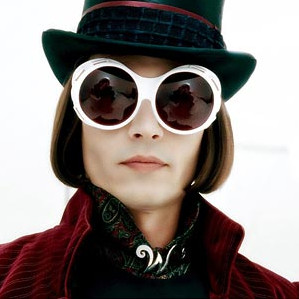

34.47% : sunglasses
18.10% : sunglass
 1.29% : velvet
 0.95% : wig
 0.85% : cowboy hat
 0.72% : sombrero
 0.64% : seat belt
 0.50% : jean
 0.44% : stole
 0.41% : poncho


In [19]:
classify(image_path="images/willy_wonka_new.jpg")

### 2.4 Experimentación y Cierre de Sesión <a class="anchor" id="incepcierre"></a>

Acabamos de concluir el apartado en el que hemos jugado con el modelo Inception v3, y visto algunas de sus limitaciones. A continuación puedes probar otras imágenes, tuyas o de internet, y ver si el modelo está confundido o no. Una vez terminado, cerraremos la sesión de TensorFlow, mediante el método correspondiente en el objeto *model*.

In [ ]:
# Prueba aquí imágenes tuyas o de internet


In [30]:
# Una vez terminado de experimentar y si no vas a continuar con el apartado 3, descomenta la siguiente línea y
# ejecuta esta celda para cerrar la sesión de TensorFlow, para así liberar los recursos de GPU.

#model.close()

### 2.5 Conclusión <a class="anchor" id="incepconclu"></a>

Este apartado mostró cómo usar el modelo Inception v3 preentrenado. Un ordenador muy caro puede tarda varias semanas en entrenar el modelo Inception, pero podemos descargar el modelo terminado de Internet y usarlo en un PC normal para clasificar las imágenes.

Desafortunadamente, el modelo Inception parece tener problemas para reconocer a las personas. Esto puede deberse al conjunto de entrenamiento que se utilizó. Ya se han publicado versiones más recientes del modelo Inception, pero es probable que también estén capacitados en el mismo conjunto de datos y, por lo tanto, también pueden tener problemas para reconocer a las personas. Se espera que los modelos futuros sean entrenados para reconocer objetos comunes como las personas.

En este tutorial hemos ocultado la implementación de TensorFlow en el archivo `inception.py` porque es un poco desordenado y puede que queramos reutilizarlo. La nueva versión de TensorFlow ya incluye Keras, una API que simplifica la carga de estos modelos ya entrenados, de modo que cualquiera pueda usar un potente clasificador de imágenes con sólo unas pocas líneas de código.

## 3. Estudio de Transferibilidad  <a class="anchor" id="datatransfer"></a>

En este apartado vamos a introducir el dataset que emplearemos para hacer Transfer Learning, pero antes de pasar a la acción, nos detendremos para estudiar cómo de transferibles son las características aprendidas en InceptionV3 para este nuevo conjunto de datos.

La siguiente figura muestra cómo fluyen los datos cuando se utiliza el modelo Inception para **Transferir el Aprendizaje** en **TensorFlow**. Primero introducimos y procesamos una imagen con el modelo Inception. Justo antes de la capa de clasificación final del modelo Inception, guardamos los llamados valores de transferencia (transfer-values) en un archivo caché.

La razón por la que se utiliza un archivo caché es que se tarda mucho tiempo en procesar una imagen con el modelo Inception. Con un ordenador portátil con una CPU de 2 GHz de cuatro núcleos puede procesar aproximadamente 3 imágenes por segundo utilizando el modelo Inception. Si cada imagen se procesa más de una vez, podemos ahorrar mucho tiempo almacenando en caché los valores de transferencia.

Los valores de transferencia también se denominan a veces valores de cuello de botella, pero es un término confuso, por lo que no se utiliza aquí.

Cuando todas las imágenes del nuevo conjunto de datos han sido procesadas a través del modelo Inception y los valores de transferencia resultantes se guardan en un archivo cache, entonces podemos usar esos valores de transferencia como entrada a otra red neuronal. Luego se entrena la segunda red neuronal usando las clases del nuevo conjunto de datos, para que la red aprenda a clasificar las imágenes en base a los valores de transferencia del modelo Inception.

En este apartado no vamos a entrenar una nueva red neuronal, sino que analizaremos las cachés de valores de transferencia para ver cómo de extrapolables son al nuevo conjunto de datos.


![Flowchart of Transfer Learning & Fine-Tuning](images/09_transfer_learning_flowchart.png)

Comencemos importando algunas librerías. Si ya las has cargado en el apartado anterior, entonces no las necesitas cargar de nuevo.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

# Funciones y clases para cargar y usar el modelo InceptionV3 con Tensorflow.
import inception

### 3.1 El Dataset: Knifey-Spoony <a class="anchor" id="transferdata"></a>

Para demostrar como usar transfer learning y fine tuning en este tutorial, usaremos un nuevo conjunto de datos llamado [Knifey-Spoony](https://github.com/Hvass-Labs/knifey-spoony) que contiene miles de imágenes de cuchillos, cucharas y tenedores sobre unos cuantos fondos diferentes. El conjunto de entrenamiento (training) contiene 4.170 imágenes y el de pruebas (test) 530 imágenes. Las clases se denominan knifey, spoony y forky como referencia a [Los Simpsons](https://www.youtube.com/watch?v=mcE0aAhbVFc).

Las imágenes en el conjunto de datos knifey-spoony fueron creadas a partir de archivos de vídeo usando un pequeño [script de Python](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/convert.py) que se ejecuta en Linux (requiere el programa `avconv` para la conversión de videos a imágenes). Esto le permite crear fácilmente conjuntos de datos muy grandes con miles de imágenes de sólo unos minutos de grabaciones de vídeo.

La descarga y la extracción del dataset ya viene automatizado en el fichero [`knifey.py`](./knifey.py). Las dimensiones de los datos ya están definidos en el módulo `knifey`, por lo que tan solo necesitamos importar las que necesitamos.

In [20]:
# Carga el dataset empleando el fichero kinfey.py
import knifey

Descarga y extrae el dataset si aún no se ha hecho. Ocupa unos 22 MB. A continuación, mostramos el contenido de la carpeta extraida.

In [21]:
knifey.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Ahora cargamos el conjunto de datos. Esto escanea los subdirectorios en busca de todas las imágenes `*.jpg` y pone los nombres de archivo en dos listas para el conjunto de entrenamiento y el conjunto de pruebas. Esto no carga realmente las imágenes, lo que se hará cuando los valores de transferencia se calculen más adelante.

Las listas de nombres de archivos se almacenan en caché en el disco duro, de modo que podemos estar seguros de que se ordenan de la misma manera cuando se recarga el conjunto de datos más tarde. Esto es importante para saber qué archivo de imagen corresponde a qué valores de transferencia.

In [22]:
data_dir = knifey.data_dir
dataset = knifey.load()

Creating dataset from the files in: data/knifey-spoony/
- Data loaded from cache-file: data/knifey-spoony/knifey-spoony.pkl


Obtengamos los nombres y el número de clases.

In [23]:
class_names = dataset.class_names
class_names

['forky', 'knifey', 'spoony']

In [57]:
num_classes = dataset.num_classes
num_classes

3

Ahora obtenemos el conjunto de entrenamiento. Esto devuelve las rutas de los ficheros para las imágenes, las clases como enteros, y las clases codificadas en arrays One-Hot.

In [24]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()

Podemos imprimir la primera ruta para ver si está bien.

In [25]:
image_paths_train[0]

'/data/documents/teaching/cursos/tl-mdsbd/data/knifey-spoony/forky/forky-03-0151.jpg'

Ahora obtenemos el conjunto de test.

In [26]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()

Imprimimos ahora la primera ruta.

In [27]:
image_paths_test[0]

'/data/documents/teaching/cursos/tl-mdsbd/data/knifey-spoony/forky/test/forky-test-01-0001.jpg'

El conjunto de datos Knifey-Spoony ha sido cargado y consiste en 4700 imágenes con etiquetas asociadas (es decir, clasificaciones de las imágenes). El conjunto de datos se divide en dos subconjuntos mutuamente excluyentes, el conjunto de entrenamiento y el conjunto de pruebas.

In [28]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		4170
- Test-set:		530


### 3.2 Funciones Auxiliares <a class="anchor" id="transferaux"></a>

####  Para Dibujar Imágenes

Esta función es utilizada para dibujar un máximo de 9 imágenes en una cuadrícula de 3x3, y escribir las clases verdaderas y previstas debajo de cada imagen.

In [29]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

#### Para Cargar Imágenes

Este conjunto de datos no carga las imágenes reales, sino que tiene una lista de las imágenes en el conjunto de entrenamiento y otra lista para las imágenes en el conjunto de pruebas. Esta función de ayuda carga algunos archivos de imagen.

In [30]:
from matplotlib.image import imread

def load_images(image_paths):
    # Carga las imágenes de disco
    images = [imread(path) for path in image_paths]

    # La convierte a un numpy array.
    return np.asarray(images)

### 3.3 Dibujar Algunas Imágenes de Prueba <a class="anchor" id="transferprueba"></a>

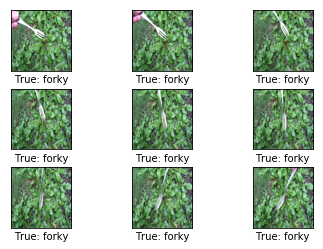

In [31]:
# Carga las primeras imágenes del conjunto de prueba
images = load_images(image_paths=image_paths_test[0:9])

# Obtenemos las clases verdades de dichas imágenes
cls_true = cls_test[0:9]

# Muestra las imágenes con sus etiquetas
plot_images(images=images, cls_true=cls_true, smooth=True)

### 3.4 Descarga del Modelo Inception  <a class="anchor" id="transfermodelo"></a>

Asumimos que el modelo Inception ya está descargado, lo cual hicimos en el apartado <a href="#incepimp">2.2</a>. Si no cerraste la sesión con el modelo, descomenta las siguientes celdas y vuelve a ejecutarlas.

In [21]:
#inception.data_dir = 'inception/'

In [23]:
#model = inception.Inception()

### 3.5 Cálculo de Valores de Transferencia <a class="anchor" id="transfercalc"></a>

Importamos una función de auxiliar para cargar en caché los valores de transferencia del modelo Inception.

In [32]:
from inception import transfer_values_cache

Asigna las rutas de ficheros para las cachés del conjunto de entrenamiento y de test (archivos .pkl).

In [33]:
file_path_cache_train = os.path.join(data_dir, 'inception-knifey-train.pkl')
file_path_cache_test = os.path.join(data_dir, 'inception-knifey-test.pkl')

In [34]:
print("Processing Inception transfer-values for training-images ...")

# Si los valores de transferencia ya han sido calculados entonces los recarga,
# si no, los calcula y los guarda en ficheros caché.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:   4170 / 4170
- Data saved to cache-file: data/knifey-spoony/inception-knifey-train.pkl


In [35]:
print("Processing Inception transfer-values for test-images ...")

# Si los valores de transferencia ya han sido calculados entonces los recarga,
# si no, los calcula y los guarda en ficheros caché.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:    530 / 530
- Data saved to cache-file: data/knifey-spoony/inception-knifey-test.pkl


Comprueba la forma (shape) del array con los valores de transferencia. Hay unas 4.170 imágenes en el conjunto de entrenamiento y por cada imagen hay unos 2048 valores de transferencia.

In [36]:
transfer_values_train.shape

(4170, 2048)

Igualmente, hay 530 imágenes para el conjunto de test con 2048 valores de transferencia para cada imagen.

In [37]:
transfer_values_test.shape

(530, 2048)

### 3.6 Función Auxiliar para Mostrar Valores de Transferencia <a class="anchor" id="transfergraphval"></a>

In [38]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Dibuja la imagen i-ésima del conjunto de test.
    image = imread(image_paths_test[i])
    plt.imshow(image, interpolation='spline16')
    plt.show()
    
    print("Transfer-values for the image using Inception model:")
    
    # Transforma los valores de transferencia en una imagen.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Dibuja la imagen para los valores de transferencia.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


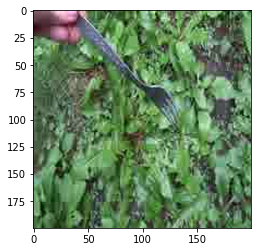

Transfer-values for the image using Inception model:


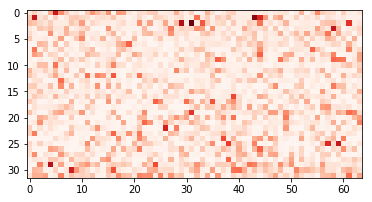

In [39]:
plot_transfer_values(i=100)

Input image:


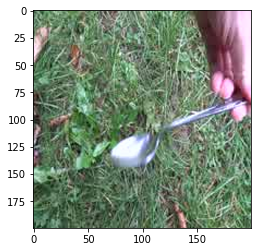

Transfer-values for the image using Inception model:


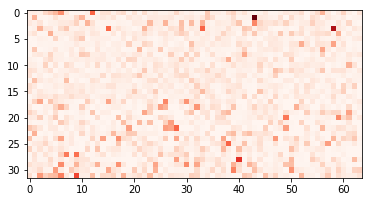

In [40]:
plot_transfer_values(i=300)

### 3.7 Análisis de Valores de Transferencia mediante PCA <a class="anchor" id="transferpca"></a>

Utilizamos el Análisis de Componentes Principales (PCA) de scikit-learn para reducir las dimensiones de la matriz (longitud del array) de los valores de transferencia de 2048 a 2 para que se puedan dibujar.

In [41]:
from sklearn.decomposition import PCA

Creamos un objeto PCA y asignamos la longitud de array objetivo a 2.

In [42]:
pca = PCA(n_components=2)

Lleva un tiempo calcular el PCA. En este caso, el conjunto de datos no es tan grande, pero de lo contrario podría seleccionar una parte más pequeña del conjunto de entrenamiento para acelerar el cálculo.

In [43]:
# transfer_values = transfer_values_train[0:3000]
transfer_values = transfer_values_train

Obtener los números de clase de las muestras que se seleccionó.

In [44]:
# cls = cls_train[0:3000]
cls = cls_train

Comprobar que el array tiene 4.170 muestras y 2.048 valores de transferencia para cada muestra.

In [45]:
transfer_values.shape

(4170, 2048)

Utilice PCA para reducir las matrices de valores de transferencia de 2048 a 2 elementos.

In [46]:
transfer_values_reduced = pca.fit_transform(transfer_values)

Comprobar que ahora es un array con 4170 muestras y 2 valores por muestra.

In [47]:
transfer_values_reduced.shape

(4170, 2)

Función de ayuda para dibujar el array reducido.

In [48]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Create an index with a random permutation to make a better plot.
    idx = np.random.permutation(len(values))
    
    # Get the color for each sample.
    colors = cmap[cls[idx]]

    # Extract the x- and y-values.
    x = values[idx, 0]
    y = values[idx, 1]

    # Plot it.
    plt.scatter(x, y, color=colors, alpha=0.5)
    plt.show()

Mostrar los valores de transferencia que se han reducido utilizando PCA. Hay 3 colores diferentes para las diferentes clases en el conjunto de datos de la Knifey-Spoony. Los colores tienen una superposición muy grande. Esto puede deberse a que la PCA no puede separar adecuadamente los valores de transferencia.

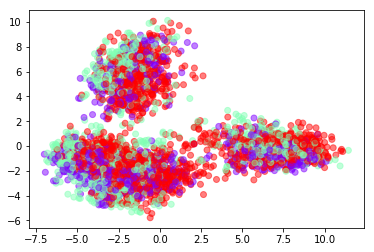

In [58]:
plot_scatter(transfer_values_reduced, cls=cls)

### 3.8 Análisis de Valores de Transferencia mediante t-SNE <a class="anchor" id="transfertsne"></a>

In [59]:
from sklearn.manifold import TSNE

Otro método para hacer la reducción de la dimensionalidad es t-SNE. Desafortunadamente, t-SNE es muy lento, así que primero usamos PCA para reducir los valores de transferencia de 2048 a 50 elementos.

In [60]:
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

Creamos un nuevo objeto t-SNE para la reducción de la dimensionalidad final y establecemos el objetivo en 2-dim.

In [61]:
tsne = TSNE(n_components=2)

Realizamos la reducción final utilizando t-SNE. La implementación actual de t-SNE en scikit-learn no puede manejar datos con muchas muestras, por lo que esto puede fallar si utilizamos el conjunto de entrenamiento completo.

In [62]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

Comprobamos que ahora es un array con 4170 muestras y 2 valores de transferencia por muestra.

In [63]:
transfer_values_reduced.shape

(4170, 2)

Mostramos los valores de transferencia que han sido reducidos a 2-dim usando t-SNE, lo que muestra una mejor separación que el gráfico PCA de arriba.

Esto significa que los valores de transferencia del modelo Inception parecen contener suficiente información para separar las imágenes de Knifey-Spoony en clases, aunque todavía hay cierta superposición, por lo que la separación no es perfecta.

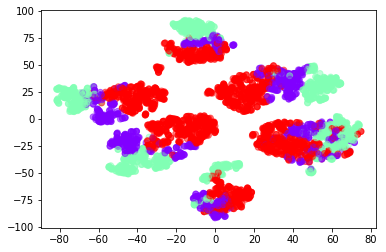

In [64]:
plot_scatter(transfer_values_reduced, cls=cls)

### 3.9 Conclusiones <a class="anchor" id="transferconc"></a>

Hemos trabajado con un conjunto de datos que emplearemos en la sesión 2 para Transfer Learning. Hemos también estudiado si la distribución de los valores de transferencia son suficientemente separables para las 3 clases, para que de este modo el clasificador final sea capaz de discriminarlos. 

## License (MIT)

Based on the TensorFlow tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.